In [1]:
import pandas as pd
import random
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import math


In [2]:
np.random.seed(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
class USBattleship(gym.Env):
    def __init__(self):
        self.observation_space = gym.spaces.Discrete(100)  # Board has 100 spaces (10x10 grid)
        self.action_space = gym.spaces.Discrete(100)  # Each action corresponds to firing at a specific cell
        self.board = np.zeros((10, 10))  # Initialize the board
        self.battleshipCP = None  # Will hold the board with battleships
        self.done = False
        self.Hit2 = 0

    def reset(self):
        """Reset the game environment and place five battleships randomly."""
        self.board = np.zeros((10, 10))
        ship_sizes = [2, 3, 3, 4, 5]  # Sizes of battleships
        for ship_size in ship_sizes:
            self.board = self.place_ship(ship_size, self.board)
        self.battleshipCP = self.board.copy()  # Save the board with battleships
        self.done = False
        self.Hit2 = 0
        return self.battleshipCP

    def place_ship(self, ship_size, board):
        """Place a ship on the board ensuring no overlap and valid placement."""
        while True:
            x = np.random.randint(0, 10)
            y = np.random.randint(0, 10)
            direction = np.random.choice(['horizontal', 'vertical'])

            if direction == 'horizontal':
                if y + ship_size <= 10 and not board[x, y:y + ship_size].any():
                    board[x, y:y + ship_size] = 1
                    break
            else:  # vertical
                if x + ship_size <= 10 and not board[x:x + ship_size, y].any():
                    board[x:x + ship_size, y] = 1
                    break
        return board

    def step(self, action):
      """Take a step by firing at a given position."""
      x, y = divmod(action, 10)  # Convert action into board coordinates
      reward = 0

      if self.battleshipCP[x, y] == 1:  # Hit
          self.battleshipCP[x, y] = 0  # Mark as hit
          self.Hit2 += 1
          reward = 1
      elif self.battleshipCP[x, y] == 0:  # Miss
          reward = -1

      # Check if all ships are sunk
      if self.Hit2 == sum([2, 3, 3, 4, 5]):
          self.done = True

      return action, reward, self.done, {}


    def render(self):
        """Render the current board state."""
        print("Current Board:")
        print(self.battleshipCP)

# Example usage
env = USBattleship()
env.reset()
env.render()
action = random.randint(0, 99)
state, reward, done, info = env.step(action)
print(f"Action: {action}, Reward: {reward}, Done: {done}")
env.render()


Current Board:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Action: 64, Reward: 1, Done: False
Current Board:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [66]:


# Hyperparameters
num_episodes = 40000
max_steps_per_episode = 99

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 10
min_exploration_rate = 0.01
exploration_decay_rate = 0.001


# Initialize environment
env = USBattleship()
state_space = 100  # Total cells (10x10 grid)
action_space = 100  # Each action corresponds to a grid cell

# Initialize Q-table
q_table = np.zeros((state_space, action_space))

# Tracking metrics
rewards_all_episodes = []
ep_count = []
tm = []
graph_step = []
graph_ep = []
reward_pre = []
meanstep = []

# Q-Learning algorithm
for episode in range(num_episodes):
    state = random.randint(0, state_space - 1)  # Initial random state
    env.reset()  # Reset environment
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode):
        # Exploration-exploitation trade-off
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state, :])  # Exploitation
        else:
            action = random.randint(0, action_space - 1)  # Exploration

        # Perform action
        new_state, reward, done, info = env.step(action)

        # Update Q-table
        q_table[state, action] = (1 - learning_rate) * q_table[state, action] + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))

        # Update state and reward
        state = new_state
        rewards_current_episode += reward

        if done:
            break

    # Decay exploration rate
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)

    # Track rewards
    rewards_all_episodes.append(rewards_current_episode)
    graph_step.append(step)
    graph_ep.append(episode)
    reward_pre.append(rewards_current_episode)

# Calculate average rewards per thousand episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), num_episodes / 100)

print("********** Average reward per thousand episodes **********\n")
count = 0
for r in rewards_per_thousand_episodes:
    avg_reward = sum(r) / 100
    print(f"{count}: {avg_reward}")
    tm.append(avg_reward)
    meanstep.append(np.mean(graph_step[count:count + 100]))
    ep_count.append(count + 100)
    count += 100





********** Average reward per thousand episodes **********

0: -77.48
100: -77.52
200: -77.16
300: -77.54
400: -78.12
500: -77.54
600: -77.46
700: -77.72
800: -78.14
900: -77.66
1000: -77.64
1100: -77.82
1200: -78.14
1300: -77.22
1400: -77.92
1500: -77.2
1600: -77.8
1700: -77.58
1800: -76.64
1900: -77.82
2000: -77.46
2100: -77.04
2200: -77.76
2300: -76.92
2400: -77.76
2500: -77.32
2600: -77.66
2700: -77.2
2800: -77.68
2900: -77.56
3000: -77.34
3100: -78.3
3200: -78.6
3300: -78.06
3400: -78.02
3500: -77.94
3600: -78.14
3700: -77.68
3800: -77.42
3900: -78.3
4000: -78.58
4100: -78.26
4200: -77.78
4300: -77.48
4400: -78.04
4500: -78.24
4600: -78.16
4700: -77.96
4800: -77.74
4900: -77.84
5000: -78.98
5100: -78.24
5200: -78.28
5300: -78.74
5400: -78.46
5500: -78.54
5600: -77.86
5700: -77.64
5800: -78.06
5900: -78.58
6000: -77.84
6100: -78.24
6200: -78.38
6300: -78.6
6400: -79.36
6500: -78.46
6600: -78.54
6700: -78.36
6800: -78.08
6900: -78.34
7000: -78.56
7100: -78.94
7200: -78.23
7300: -78.

Text(0.5, 1.0, 'Mean Step vs  Episodes')

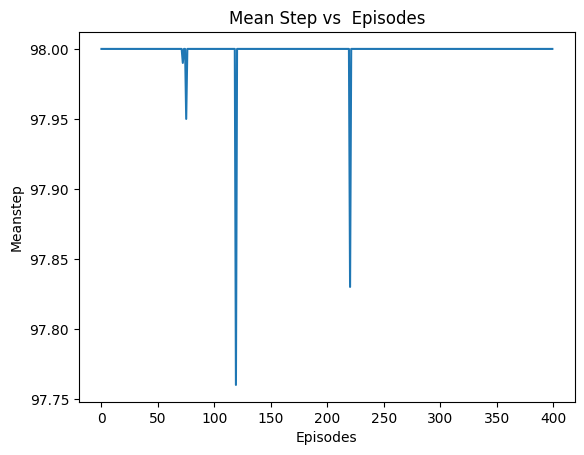

In [67]:
plt.plot(meanstep)
plt.xlabel('Episodes')
plt.ylabel('Meanstep')
plt.title('Mean Step vs  Episodes')

Text(0.5, 1.0, 'Reward vs  Episodes')

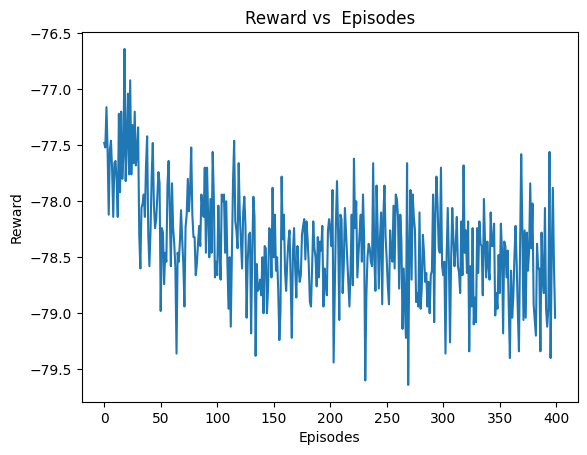

In [68]:
plt.plot(tm)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward vs  Episodes')

In [69]:
env = USBattleship()

env.reset()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [94]:

class USBattleship(gym.Env):
    def __init__(self):
        self.observation_space = gym.spaces.Discrete(100)  # Board has 100 spaces (10x10 grid)
        self.action_space = gym.spaces.Discrete(100)  # Each action corresponds to firing at a specific cell
        self.board = np.zeros((10, 10))  # Initialize the board
        self.battleshipCP = None  # Will hold the board with battleships
        self.done = False
        self.Hit2 = 0

    def reset(self):
        """Reset the game environment and place five battleships randomly."""
        self.board = np.zeros((10, 10))
        ship_sizes = [2, 3, 3, 4, 5]  # Sizes of battleships
        for ship_size in ship_sizes:
            self.board = self.place_ship(ship_size, self.board)
        self.battleshipCP = self.board.copy()  # Save the board with battleships
        self.done = False
        self.Hit2 = 0
        return self.battleshipCP

    def place_ship(self, ship_size, board):
        """Place a ship on the board ensuring no overlap and valid placement."""
        while True:
            x = np.random.randint(0, 10)
            y = np.random.randint(0, 10)
            direction = np.random.choice(['horizontal', 'vertical'])

            if direction == 'horizontal':
                if y + ship_size <= 10 and not board[x, y:y + ship_size].any():
                    board[x, y:y + ship_size] = 1
                    break
            else:  # vertical
                if x + ship_size <= 10 and not board[x:x + ship_size, y].any():
                    board[x:x + ship_size, y] = 1
                    break
        return board

    def step(self, action):
        """Take a step by firing at a given position."""
        x, y = divmod(action, 10)  # Convert action into board coordinates
        reward = 0

        if self.battleshipCP[x, y] == 1:  # Hit
            self.battleshipCP[x, y] = 0  # Mark as hit
            self.Hit2 += 1
            reward = 1
        elif self.battleshipCP[x, y] == 0:  # Miss
            reward = -1

        # Check if all ships are sunk
        if self.Hit2 == sum([2, 3, 3, 4, 5]):
            self.done = True
        if self.Hit2 == 1:
            self.battleshiphit = True

        return action, reward,battleshiphit,self.done, {}

    def render(self):
        """Render the current board state."""
        print("Current Board:")
        print(self.battleshipCP)


In [95]:



# Hyperparameters
num_episodes = 40000
max_steps_per_episode = 99

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1.0
max_exploration_rate = 10.0
min_exploration_rate = 0.01
exploration_decay_rate = 0.001


# Initialize environment
env = USBattleship()
state_space = 100  # Total cells (10x10 grid)
action_space = 100  # Each action corresponds to a grid cell

# Initialize two Q-tables for Double Q-Learning
q_table1 = np.zeros((state_space, action_space))
q_table2 = np.zeros((state_space, action_space))

# Tracking metrics
rewards_all_episodes = []
rewards_all_episodes = []
ep_count = []
tm = []
graph_step = []
graph_ep = []
reward_pre = []
meanstep = []

# Double Q-Learning algorithm
for episode in range(num_episodes):
    env.reset()
    state = random.randint(0, state_space - 1)  # Random initial state
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode):
        # Exploration-exploitation trade-off
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            # Exploit
            action = np.argmax(q_table1[state, :] + q_table2[state, :])
        else:
            # Explore
            action = env.action_space.sample()

        # Take the action and observe the outcome
        new_state, reward, done,battleshiphit, _ = env.step(action)

        # Update one of the Q-tables
        if battleshiphit == False:
            q_table1[state, action] = (1 - learning_rate) * q_table1[state, action] + \
                                      learning_rate * (reward + discount_rate * q_table2[new_state, np.argmax(q_table1[new_state, :])])
        else:
            q_table2[state, action] = (1 - learning_rate) * q_table2[state, action] + \
                                      learning_rate * (reward + discount_rate * q_table1[new_state, np.argmax(q_table2[new_state, :])])

        state = new_state
        rewards_current_episode += reward

        if done:
            break

    # Decay exploration rate
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)


    # Track rewards
    rewards_all_episodes.append(rewards_current_episode)
    graph_step.append(step)
    graph_ep.append(episode)
    reward_pre.append(rewards_current_episode)

# Calculate average rewards per thousand episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), num_episodes / 100)

print("********** Average reward per thousand episodes **********\n")
count = 0
for r in rewards_per_thousand_episodes:
    avg_reward = sum(r) / 100
    print(f"{count}: {avg_reward}")
    tm.append(avg_reward)
    meanstep.append(np.mean(graph_step[count:count + 100]))
    ep_count.append(count + 100)
    count += 100



********** Average reward per thousand episodes **********

0: -78.02
100: -76.52
200: -77.26
300: -77.32
400: -77.46
500: -77.82
600: -77.74
700: -77.62
800: -77.4
900: -77.58
1000: -77.74
1100: -78.1
1200: -77.2
1300: -77.32
1400: -77.88
1500: -77.6
1600: -77.4
1700: -77.44
1800: -77.64
1900: -77.88
2000: -77.26
2100: -78.08
2200: -77.64
2300: -76.03
2400: -77.3
2500: -77.26
2600: -77.56
2700: -77.26
2800: -77.66
2900: -77.5
3000: -77.86
3100: -77.78
3200: -79.24
3300: -78.56
3400: -78.68
3500: -79.32
3600: -78.14
3700: -79.14
3800: -79.1
3900: -79.1
4000: -80.4
4100: -79.74
4200: -80.02
4300: -80.3
4400: -80.0
4500: -80.8
4600: -80.08
4700: -80.6
4800: -80.66
4900: -81.2
5000: -81.14
5100: -81.1
5200: -81.14
5300: -81.54
5400: -81.36
5500: -80.9
5600: -81.62
5700: -81.8
5800: -81.68
5900: -81.16
6000: -82.06
6100: -82.6
6200: -82.64
6300: -81.68
6400: -82.58
6500: -82.46
6600: -82.24
6700: -82.98
6800: -83.46
6900: -82.44
7000: -82.6
7100: -82.96
7200: -83.46
7300: -82.94
7400: -83.

Text(0.5, 1.0, 'Mean Step vs  Episodes')

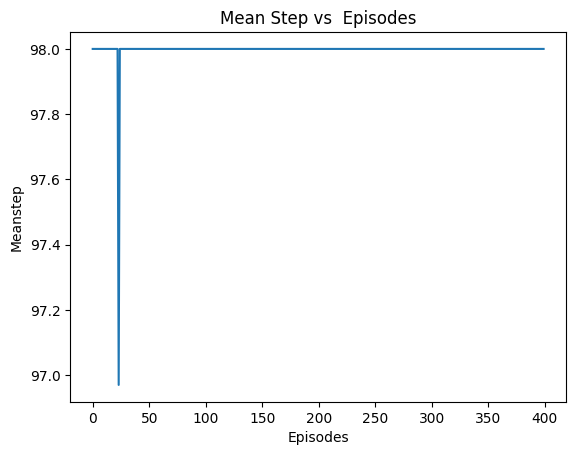

In [96]:
plt.plot(meanstep)
plt.xlabel('Episodes')
plt.ylabel('Meanstep')
plt.title('Mean Step vs  Episodes')

Text(0.5, 1.0, 'Reward vs  Episodes')

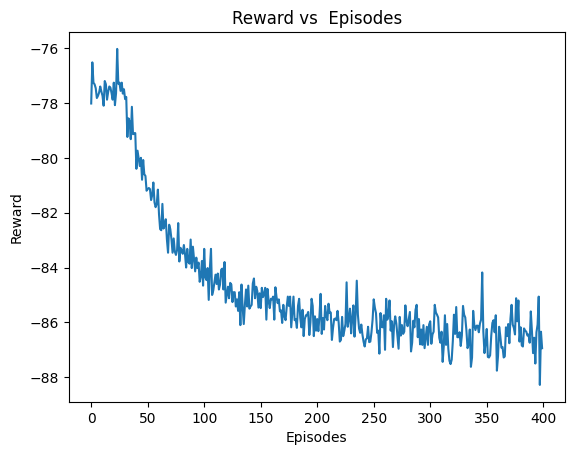

In [98]:
plt.plot(tm)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward vs  Episodes')